# 3. Topic Modeling with NMF and SVD

Topic modeling is a great way to get started with matrix factorizations. We start with a **term-document matrix**:

<img src="images/document_term.png" alt="term-document matrix" style="width: 80%"/>
(source: [Introduction to Information Retrieval](http://player.slideplayer.com/15/4528582/#))

We can decompose this into one tall thin matrix times one wide short matrix (possibly with a diagonal matrix in between).

Notice that this representation does not take into account word order or sentence structure.  It's an example of a **bag of words** approach.

### Motivation

Consider the most extreme case - reconstructing the matrix using an outer product of two vectors. Clearly, in most cases we won't be able to reconstruct the matrix exactly. But if we had one vector with the relative frequency of each vocabulary word out of the total word count, and one with the average number of words per document, then that outer product would be as close as we can get.

Now consider increasing that matrices to two columns and two rows. The optimal decomposition would now be to cluster the documents into two groups, each of which has as different a distribution of words as possible to each other, but as similar as possible amongst the documents in the cluster. We will call those two groups "topics". And we would cluster the words into two groups, based on those which most frequently appear in each of the topics. 

### In today's class

We'll take a dataset of documents in several different categories, and find topics (consisting of groups of words) for them.  Knowing the actual categories helps us evaluate if the topics we find make sense.

We will try this with two different matrix factorizations: **Singular Value Decomposition (SVD)** and **Non-negative Matrix Factorization (NMF)**

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

## Additional Resources

- [Data source](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html): Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.
- [Chris Manning's book chapter](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) on matrix factorization and LSI 
- Scikit learn [truncated SVD LSI details](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

### Other Tutorials
- [Scikit-Learn: Out-of-core classification of text documents](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): uses [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) dataset (Reuters articles labeled with ~100 categories), HashingVectorizer
- [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html): uses [British and French Literature dataset](https://de.dariah.eu/tatom/datasets.html) of Jane Austen, Charlotte Bronte, Victor Hugo, and more

## Set up data

Scikit Learn comes with a number of built-in datasets, as well as loading utilities to load several standard external datasets. This is a [great resource](http://scikit-learn.org/stable/datasets/), and the datasets include Boston housing prices, face images, patches of forest, diabetes, breast cancer, and more.  We will be using the newsgroups dataset.

Newsgroups are discussion groups on Usenet, which was popular in the 80s and 90s before the web really took off.  This dataset includes 18,000 newsgroups posts with 20 topics.  

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target .shape

((2034,), (2034,))

Let's look at some of the data.  Can you guess which category these messages are in?

In [5]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

hint: definition of *perijove* is the point in the orbit of a satellite of Jupiter nearest the planet's center 

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

The target attribute is the integer index of the category.

In [7]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [8]:
num_topics, num_top_words = 6, 8

Next, scikit learn has a method that will extract all the word counts for us.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [11]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [12]:
vocab = np.array(vectorizer.get_feature_names())

In [13]:
vocab.shape

(26576,)

In [14]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype='<U80')

## Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

We would clearly expect that the words that appear most frequently in one topic would appear less frequently in the other - otherwise that word wouldn't make a good choice to separate out the two topics. Therefore, we expect the topics to be **orthogonal**.

The SVD algorithm factorizes a matrix into one matrix with **orthogonal columns** and one with **orthogonal rows** (along with a diagonal matrix, which contains the **relative importance** of each factor).

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

SVD is an **exact decomposition**, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations ([winning entry for Netflix Prize](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis (will be covered later in course)

In [15]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 24s, sys: 2.17 s, total: 1min 26s
Wall time: 38.4 s


In [16]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


Confirm this is a decomposition of the input.

In [17]:
#Exercise: confrim that U, s, Vh is a decomposition of the var Vectors

#### Answer

In [18]:
reconstructed = U @ np.diag(s) @ Vh

In [19]:
np.linalg.norm(reconstructed - vectors)

9.607821029689433e-12

In [20]:
np.allclose(reconstructed, vectors)

True

The core idea is to multiply the decomposed matrices again and check with the original matrix is to see if the values are similar. The tip is that don't forget to convert $s$ into a diagonal matrix by using $np.diag$. As we see that the norm of the differences between reconstructed matrix and original matrix is quite small, therefore we know that this is a good decomposition of the original matrix

Confirm that U, V are orthonormal

#### Answer

In [21]:
#Exercise: Confirm that U, Vh are orthonormal

In [22]:
np.allclose(np.matmul(U.T, U), np.eye(U.shape[0]))

True

In [23]:
np.allclose(np.matmul(Vh, Vh.T), np.eye(Vh.shape[0]))

True

An orthogonal matrix is a square matrix whose columns and rows are orthogonal unit vectors where
$Q^TQ = QQ^T = I$ where $I$ is an identity matrix

#### Topics

What can we say about the singular values s?

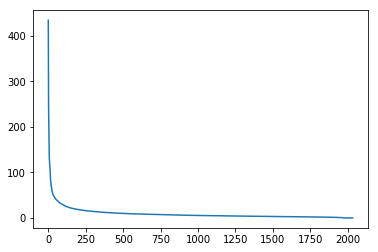

In [24]:
plt.plot(s);

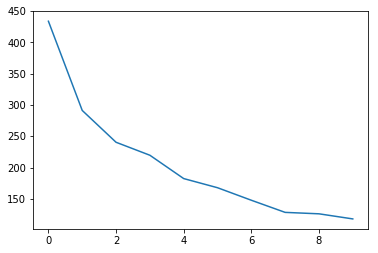

In [25]:
plt.plot(s[:10])

In [26]:
num_top_words = 8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [27]:
show_topics(Vh[:20])

['critus ditto propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material',
 'larson theory universe physical den p2 p3 p1',
 'den p2 p3 p1 radius p12 p23 p13',
 'judas hanging reply db mr decenso greek death',
 'atheists atheism religious people religion prophecy matthew messiah',
 'space graphics people like sgi research package society',
 'telescope word national observatory satellite atheists infrared prefix',
 'people like nasa don think just time gay',
 'ra s

We get topics that match the kinds of clusters we would expect! This is despite the fact that this is an **unsupervised algorithm** - which is to say, we never actually told the algorithm how our documents are grouped.

We will return to SVD in **much more detail** later.  For now, the important takeaway is that we have a tool that allows us to exactly factor a matrix into orthogonal columns and orthogonal rows.

In the example of the SVD diagram above, the original matrix is $A$ (words by posts).
$U$ has (words by topics), and $V^T$ has (topics by posts)

## Non-negative Matrix Factorization (NMF)

#### Motivation

<img src="images/face_pca.png" alt="PCA on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

A more interpretable approach:

<img src="images/face_outputs.png" alt="NMF on Faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

#### Idea

Rather than constraining our factors to be *orthogonal*, another idea would to constrain them to be *non-negative*. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be **more easily interpretable** (and this is the reason behind NMF's popularity). 

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix.  NMF is NP-hard and non-unique.  There are a number of variations on it, created by adding different constraints. 

#### Applications of NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (our problem!)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

**More Reading**:

- [The Why and How of Nonnegative Matrix Factorization](https://arxiv.org/pdf/1401.5226.pdf)

### NMF from sklearn

First, we will use [scikit-learn's implementation of NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html):

In [28]:
m, n = vectors.shape
d = 5  # num topics

In [29]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [30]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

[Term Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [31]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [32]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [33]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

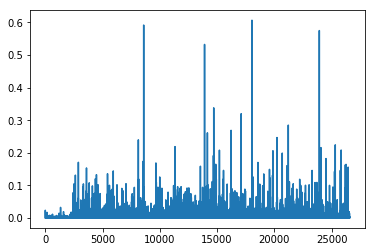

In [34]:
plt.plot(clf.components_[0])

In [35]:
clf.reconstruction_err_

43.71292605795279

### NMF in summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:
- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

### NMF from scratch in numpy, using SGD

#### Gradient Descent

The key idea of standard **gradient descent**:
1. Randomly choose some weights to start
2. Loop:
    - Use weights to calculate a prediction
    - Calculate the derivative of the loss
    - Update the weights
3. Repeat step 2 lots of times.  Eventually we end up with some decent weights.

**Key**: We want to decrease our loss and the derivative tells us the direction of **steepest descent**.  

Note that *loss*, *error*, and *cost* are all terms used to describe the same thing.

Let's take a look at the [Gradient Descent Intro notebook](Extra-Gradient-Descent-Introduction.ipynb) (originally from the [fast.ai deep learning course](https://github.com/fastai/courses)).

#### Stochastic Gradient Descent (SGD)

**Stochastic gradient descent** is an incredibly useful optimization method (it is also the heart of deep learning, where it is used for backpropagation).

For *standard* gradient descent, we evaluate the loss using **all** of our data which can be really slow.  In *stochastic* gradient descent, we evaluate our loss function on just a sample of our data (sometimes called a *mini-batch*).  We would get different loss values on different samples of the data, so this is *why it is stochastic*.  It turns out that this is still an effective way to optimize, and it's much more efficient!

We can see how this works in this [excel spreadsheet](graddesc.xlsm) (originally from the [fast.ai deep learning course](https://github.com/fastai/courses)).

**Resources**:
- [SGD Lecture from Andrew Ng's Coursera ML course](https://www.coursera.org/learn/machine-learning/lecture/DoRHJ/stochastic-gradient-descent)
- <a href="http://wiki.fast.ai/index.php/Stochastic_Gradient_Descent_(SGD)">fast.ai wiki page on SGD</a>
- [Gradient Descent For Machine Learning](http://machinelearningmastery.com/gradient-descent-for-machine-learning/) (Jason Brownlee- Machine Learning Mastery)
- [An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)

#### Applying SGD to NMF

**Goal**: Decompose $V\;(m \times n)$ into $$V \approx WH$$ where $W\;(m \times d)$ and $H\;(d \times n)$, $W,\;H\;>=\;0$, and we've minimized the Frobenius norm of $V-WH$.

**Approach**: We will pick random positive $W$ & $H$, and then use SGD to optimize.

**To use SGD, we need to know the gradient of the loss function.**

**Sources**:
- Optimality and gradients of NMF: http://users.wfu.edu/plemmons/papers/chu_ple.pdf
- Projected gradients: https://www.csie.ntu.edu.tw/~cjlin/papers/pgradnmf.pdf

In [36]:
lam = 1e3
lr = 1e-2
m, n = vectors_tfidf.shape

In [37]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [38]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [42]:
def penalty(M, mu):
    return np.where(M >= mu, 0, np.min(M - mu, 0))

In [44]:
mu = 1e-6

def grads(M, W, H):
    R = W @ H - M
    dW = R @ H.T + penalty(W, mu)
    dH = W.T @ R + penalty(H, mu) * lam
    
    return dW, dH

In [45]:
def upd(M, W, H, lr):
    dW, dH = grads(M,W,H)
    W -= lr * dW
    H -= lr * dH

In [51]:
def report(M, W, H):
    frobenius_norm = np.linalg.norm(M - W @ H)
    W_min = W.min()
    H_min = H.min()
    W_num_negative = (W < 0).sum()
    H_num_negative = (H < 0).sum()
    
    print(frobenius_norm, W_min, H_min, W_num_negative, H_num_negative)

In [52]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [53]:
report(vectors_tfidf, W, H)

44.42507734197007 1.2018055004023166e-06 7.114461467507729e-08 0 0


In [54]:
upd(vectors_tfidf, W, H, lr)

In [55]:
report(vectors_tfidf, W, H)

44.41737456691077 -0.0007278062948647149 -7.151468460677116e-05 147 280


In [59]:
for i in range(10): 
    upd(vectors_tfidf, W, H, lr)
    
    if i % 10 == 0:
        report(vectors_tfidf, W, H)

44.086931932928955 -0.017262432802762302 -0.0007269720327979388 1279 8010


In [60]:
show_topics(H)

['god don like people think know just ve',
 'god people think don does know say just',
 'space people don just nasa like know does',
 'just space don people know like think did',
 'space don know thanks people just like think']

This is painfully slow to train!  Lots of parameter fiddling and still slow to train (or explodes).

### PyTorch

[PyTorch](http://pytorch.org/) is a Python framework for tensors and dynamic neural networks with GPU acceleration.  Many of the core contributors work on Facebook's AI team.  In many ways, it is similar to Numpy, only with the increased parallelization of using a GPU.

From the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [learning by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

**Note about GPUs**: If you are not using a GPU, you will need to remove the `.cuda()` from the methods below. GPU usage is not required for this course, but I thought it would be of interest to some of you.  To learn how to create an AWS instance with a GPU, you can watch the [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).

In [61]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In [62]:
def V(M):
    return Variable(M, requires_grad=True)

In [63]:
v = vectors_tfidf.todense()

In [65]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [286]:
mu = 1e-5

In [75]:
def penalty_t(M, mu):
    # Clamp is for clipping
    return (M < mu).type(torch.FloatTensor) * torch.clamp(M - mu, max=0.0)

def grads_t(M, W, H):
    # mm is matrix multiplication
    R = W.mm(H) - M
    dW = R.mm(H.t()) + penalty_t(W, mu) * lam
    dH = W.t().mm(R) + penalty_t(H, mu) * lam
    
    return dW, dH # dW, dH

def upd_t(M, W, H, lr):
    dW, dH = grads_t(M, W, H)
    
    # sub_ is subtraction (-=)
    W.sub_(lr * dW)
    H.sub_(lr * dH)

def report_t(M,W,H):
    frobenius_norm = (M - W.mm(H)).norm(2)
    W_min = W.min()
    H_min = H.min()
    W_num_neg = (W < 0).sum()
    H_num_neg = (H < 0).sum()
    
    print(frobenius_norm, W_min, H_min, W_num_neg, H_num_neg)

In [76]:
# Float for the data type of the tensor
t_W = torch.FloatTensor(m, d)
t_H = torch.FloatTensor(d, n)

# Initialize normal random variable, abs_ for absolute value
t_W.normal_(std=0.01).abs_()
t_H.normal_(std=0.01).abs_()

tensor([[ 1.6286e-02,  1.4649e-02,  6.1067e-03,  ...,  1.0400e-02,
          1.6754e-03,  4.7700e-04],
        [ 9.6114e-04,  3.7548e-03,  1.2726e-02,  ...,  1.1802e-02,
          4.7749e-03,  4.0470e-04],
        [ 1.1812e-03,  1.2323e-02,  9.0901e-03,  ...,  9.7889e-04,
          1.4344e-02,  4.3150e-03],
        [ 8.2643e-03,  4.3860e-04,  3.1431e-03,  ...,  6.9833e-03,
          2.1697e-03,  1.6532e-02],
        [ 1.0421e-02,  5.3610e-03,  1.4610e-02,  ...,  2.7709e-03,
          5.6069e-03,  1.9287e-02]])

In [77]:
d = 6
lam = 100
lr = 0.05

In [79]:
for i in range(100): 
    upd_t(t_vectors, t_W, t_H, lr)
    
    if i % 100 == 0: 
        report_t(t_vectors, t_W, t_H)
        lr *= 0.9

tensor(43.7297) tensor(1.00000e-03 *
       -9.8265) tensor(1.00000e-03 *
       -3.6094) tensor(1726) tensor(28553)


In [80]:
show_topics(t_H.cpu().numpy())

['don just think people like know time ve',
 'thanks graphics files image file program windows format',
 'ico bobbe tek bronx beauchaine manhattan sank queens',
 'god jesus bible believe does christian atheism belief',
 'space nasa shuttle launch orbit station lunar data']

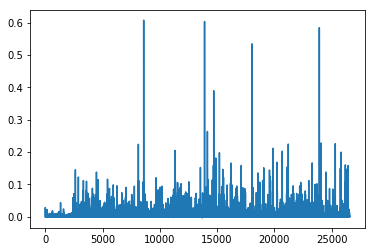

In [81]:
plt.plot(t_H.cpu().numpy()[0])

In [89]:
t_W.mm(t_H).max()

tensor(0.3616)

In [90]:
t_vectors.max()

tensor(1.)

### PyTorch: autograd

Above, we used our knowledge of what the gradient of the loss function was to do SGD from scratch in PyTorch.  However, PyTorch has an automatic differentiation package, [autograd](http://pytorch.org/docs/autograd.html) which we could use instead.  This is really useful, in that we can use autograd on problems where we don't know what the derivative is.  

The approach we use below is very general, and would work for almost any optimization problem.

In PyTorch, Variables have the same API as tensors, but Variables remember the operations used on to create them.  This lets us take derivatives.

#### PyTorch Autograd Introduction

Example taken from [this tutorial](http://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial.html) in the official documentation.

In [92]:
x = Variable(torch.ones(2, 2), requires_grad=True)
print(x)

tensor([[ 1.,  1.],
        [ 1.,  1.]])


In [93]:
print(x.data)

tensor([[ 1.,  1.],
        [ 1.,  1.]])


In [94]:
print(x.grad)

None


In [95]:
y = x + 2
print(y)

tensor([[ 3.,  3.],
        [ 3.,  3.]])


In [97]:
z = y * y * 3
out = z.sum()
print(z)
print(out)

tensor([[ 27.,  27.],
        [ 27.,  27.]])
tensor(108.)


In [98]:
out.backward()
print(x.grad)

tensor([[ 18.,  18.],
        [ 18.,  18.]])


#### Using Autograd for NMF

In [99]:
lam = 1e6

In [101]:
pW = Variable(torch.FloatTensor(m,d), requires_grad=True)
pH = Variable(torch.FloatTensor(d,n), requires_grad=True)

pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_()

tensor([[ 1.4137e-02,  5.2998e-03,  5.9771e-03,  ...,  5.6878e-03,
          1.9665e-03,  5.0458e-03],
        [ 1.1483e-02,  1.1852e-02,  4.4901e-03,  ...,  1.0046e-02,
          1.7982e-03,  3.5121e-03],
        [ 5.2066e-03,  2.0261e-03,  7.2210e-03,  ...,  9.9225e-03,
          1.5247e-02,  2.4002e-03],
        [ 2.0218e-02,  2.4467e-03,  3.3551e-02,  ...,  1.6268e-02,
          3.3147e-03,  4.9117e-03],
        [ 3.6556e-03,  1.5872e-02,  7.5803e-03,  ...,  7.9519e-03,
          1.8377e-03,  8.9859e-03],
        [ 1.0534e-02,  6.0466e-03,  2.7398e-03,  ...,  6.2565e-03,
          8.7262e-03,  5.8336e-03]])

In [105]:
def report():
    W, H = pW.data, pH.data
    print((M-pW.mm(pH)).norm(2).data[0], W.min(), H.min(), (W<0).sum(), (H<0).sum())

def penalty(A):
    return torch.pow((A < 0).type(torch.FloatTensor) * torch.clamp(A, max=0.), 2)

def penalize():
    return penalty(pW).mean() + penalty(pH).mean()

def loss():
    return (M - pW.mm(pH)).norm(2) + penalize() * lam

In [106]:
M = Variable(t_vectors)

In [108]:
opt = torch.optim.Adam([pW, pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
report()

tensor(44.4394) tensor(1.00000e-06 *
       2.7027) tensor(1.00000e-08 *
       1.5103) tensor(0) tensor(0)


/Users/alvind/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


How to apply SGD, using autograd:

In [109]:
for i in range(1000): 
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    if i % 100 == 99: 
        report()
        lr *= 0.9     # learning rate annealling

/Users/alvind/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


tensor(43.9669) tensor(1.00000e-04 *
       -9.5574) tensor(1.00000e-03 *
       -1.3248) tensor(252) tensor(11982)


KeyboardInterrupt: 

In [110]:
h = pH.data.cpu().numpy()
show_topics(h)

['news science people nasa dc real station time',
 'ray help files using mail ftp like software',
 'kent know christian word people did like objective',
 'isn like god spacecraft people did moral sex',
 'pc thanks does info files data edu program',
 'thanks think morality nice god just try code']

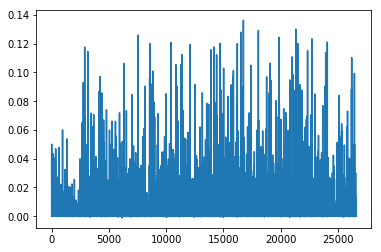

In [112]:
plt.plot(h[0])

### Comparing Approaches

#### Scikit-Learn's NMF
- Fast
- No parameter tuning
- Relies on decades of academic research, took experts a long time to implement

<img src="images/nimfa.png" alt="research on NMF" style="width: 80%"/>
source: [Python Nimfa Documentation](http://nimfa.biolab.si/)

#### Using PyTorch and SGD
- Took us an hour to implement, didn't have to be NMF experts
- Parameters were fiddly
- Not as fast (tried in numpy and was so slow we had to switch to PyTorch)

## Truncated SVD

We saved a lot of time when we calculated NMF by only calculating the subset of columns we were interested in. Is there a way to get this benefit with SVD? Yes there is! It's called truncated SVD.  We are just interested in the vectors corresponding to the **largest** singular values.

<img src="images/svd_fb.png" alt="" style="width: 80%"/>
(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

#### Shortcomings of classical algorithms for decomposition:

- Matrices are "stupendously big"
- Data are often **missing or inaccurate**.  Why spend extra computational resources when imprecision of input limits precision of the output?
- **Data transfer** now plays a major role in time of algorithms.  Techniques the require fewer passes over the data may be substantially faster, even if they require more flops (flops = floating point operations).
- Important to take advantage of **GPUs**.

(source: [Halko](https://arxiv.org/abs/0909.4061))

#### Advantages of randomized algorithms:

- inherently stable
- performance guarantees do not depend on subtle spectral properties
- needed matrix-vector products can be done in parallel

(source: [Halko](https://arxiv.org/abs/0909.4061))

## End